In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(conn, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(conn)
session

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
t_min, t_avg, t_max = calc_temps('2015-08-21', '2016-08-20')[0]
print(t_min, t_avg, t_max)

56.0 74.4534585824082 86.0


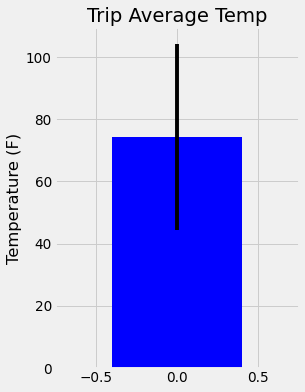

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ptp_error = t_max - t_min
plt.figure(figsize=(4,6), dpi=70)
plt.bar(0,t_avg, yerr = ptp_error, color = 'blue')
plt.xlim(-0.75, 0.75)
plt.ylabel('Temperature (F)')
plt.title("Trip Average Temp")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2015-08-21"
end_date = "2016-08-20"

def precipation_values(start_date, end_date):
    sel = [Station.station, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    results = session.query(*sel).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date)\
        .order_by(func.sum(Measurement.prcp).desc()).all()

    results= pd.DataFrame(results, columns=['station', 'lat', 'long', 'elevation', 'totalrain'])
    
    return results

df = precipation_values(start_date, end_date)
df




,station,lat,long,elevation,totalrain
0,USC00516128,21.33310,-157.80250,152.4,175.29
1,USC00519281,21.45167,-157.84889,32.9,106.02
2,USC00513117,21.42340,-157.80150,14.6,71.88
3,USC00519523,21.33556,-157.71139,19.5,54.75
4,USC00514830,21.52130,-157.83740,7.0,42.93
5,USC00519397,21.27160,-157.81680,3.0,23.28
6,USC00517948,21.39340,-157.97510,11.9,4.56
7,USC00511918,21.31520,-157.99920,0.9,3.95
8,USC00518838,21.49920,-158.01110,306.6,0.00


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("08-21")

[(67.0, 76.4, 83.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-08-01'
end = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
start_date = dt.datetime.strptime(start, '%Y-%m-%d')
end_date = dt.datetime.strptime(end, '%Y-%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
trip_dates = []
values = []
while (start_date <= end_date):
    trip_dates.append(dt.datetime.strftime(start_date, '%Y-%m-%d'))
    datestr = dt.datetime.strftime(start_date, '%m-%d')
    values.append(list(np.ravel(daily_normals(datestr))))
    start_date += dt.timedelta(days = 1)

values


[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
values_df = pd.DataFrame(values, columns=['t_min', 't_avg', 't_max'])
values_df['Date'] = trip_dates
df = values_df.set_index('Date')
df

,t_min,t_avg,t_max
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


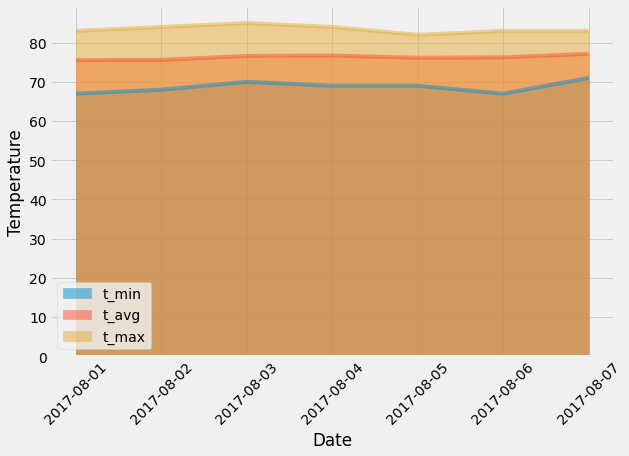

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, figsize=(9,6), legend=True)
plt.xticks(rotation=45)
plt.ylabel('Temperature')
plt.show()

## Close Session

In [41]:
session.close()